# [RNN(Recurrent Neural Networks)](https://ko.wikipedia.org/wiki/%EC%88%9C%ED%99%98_%EC%8B%A0%EA%B2%BD%EB%A7%9D)

- RNN이란 Recurrent Neural Networks의 약자로, 순환 신경망을 뜻합니다. 순환 신경망이라는 이름은 입력받는 신호의 길이가 한정되지 않은 동적 데이터를 처리한다는 점에서 붙여진 이름입니다.    
- RNN은 입력과 출력을 시퀀스 단위로 처리합니다.(시퀀스란 문장 같은 단어가 나열된 것을 뜻합니다.)    

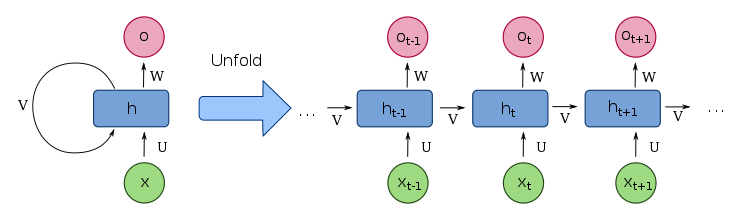

RNN은 입력과 출력의 길이를 다르게 설계할 수 있으며 이를 통해 다양한 용도로 사용할 수 있습니다.

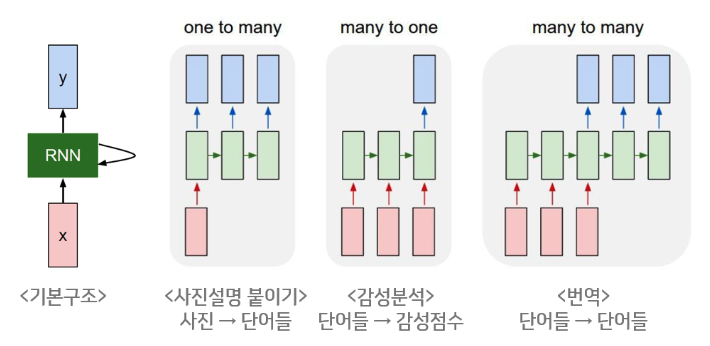

## Vanilla RNN
- $h_t$: 은닉층
- $y_t$: 출력층
- $X_t$: 입력층
- $tanh()$: 비선형 활성화 함수 

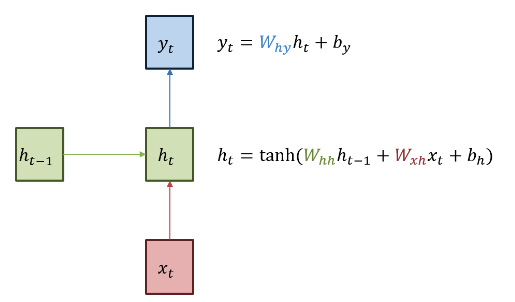

만약 벡터의 차원을 $d$라고 하고, 은닉 상태의 크기를 $D_h$라고 한다면,  
- $x_t: (d * 1)$  
- $W_x: (D_h * d)$    
- $W_h: (D_h * D_h)$    
- $h_(t-1): (D_h * 1)$   
- $b: (D_h *1)$   

RNN 은닉층 연산을 아래와 같이 표현할 수 있다.

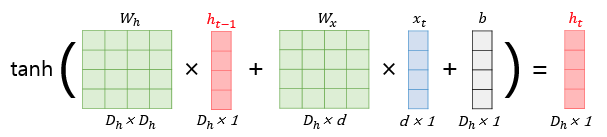

## [LSTM(Long Short Term Memory)](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
   
> Vanilla RNN은 관련 정보와 그 정보를 사용하는 지점 사이 거리가 멀 경우 역전파시 그래디언트가 점차 줄어 학습능력이 크게 저하되는 것으로 알려져 있습니다. 이를 `vanishing gradient problem`이라고 합니다.    
  
이 문제를 극복하기 위해서 고안된 것이 바로 LSTM입니다.

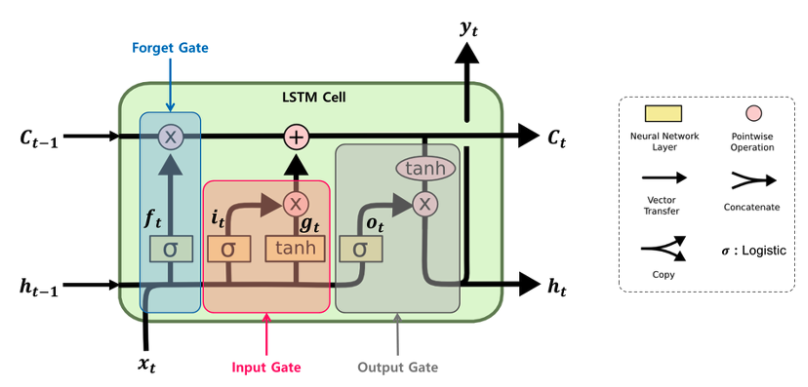

### LSTM 구조 설명
LSTM의 핵심은 cell state인데, 모듈 그림에서 수평으로 그어진 윗 선에 해당한다.  
Cell state는 컨베이어 벨트와 같아서, 작은 linear interaction만을 적용히키면서 전체 체인을 계속 구동시킨다.  
  
Cell state에 뭔가를 더하거나 없앨 수 있는데, 이 방법을 Gate라고 한다.

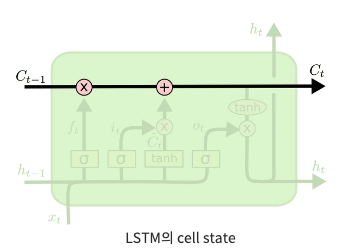

아래 그림은 sigmoid layer(0과 1 사이의 숫자를 내보냄)와 pointwise 곱셈을 나타낸 것이다.

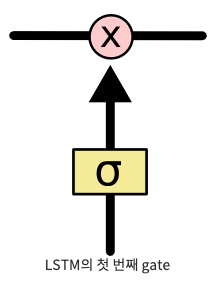

- Forget Gate   
과거 정보를 얼마나 잊을지에 대한 단계이다. 결과 값이 1이면 "이전 상태의 모든 정보를 보존"가 되고, 0이면 "이전 상태의 모든 정보를 삭제"가 된다.

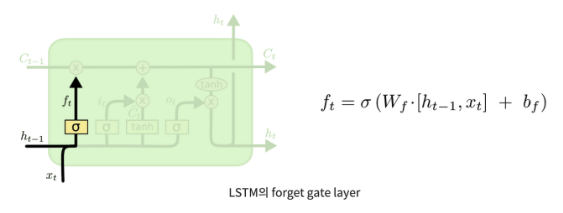

- Input Gate  
현재 정보를 얼마나 기억할 것인지에 대한 단계이다.

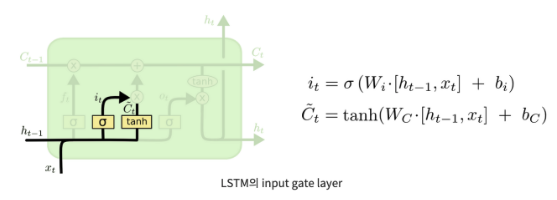

- State Update  
이전 cell state인 C(t-1)를 업데이트해서 새로운 cell state인 C(t)를 만드는 단계이다.

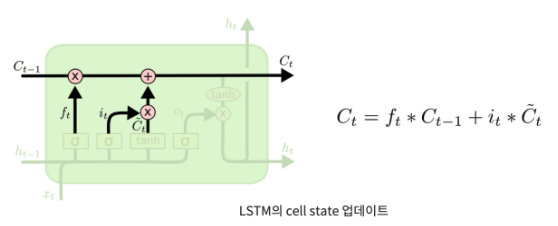

- Output Gate   
다음 state로 내보낼 output(hidden state)을 구하는 단계이다.

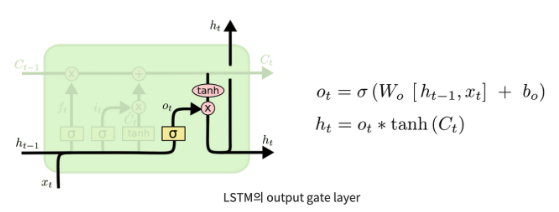

## GRU(Gated Recurrent Unit)
GRU는 LSTM과 비슷한 이유로 만들어졌으며, LSTM보다 구조가 단순하다.  
  
- Update Gate
  > LSTM의 Forget Gate와 Input Gate를 합친 Gate이다. 이전의 정보를 얼마나 통과시킬지 결정하는 Gate이다.  
- Rest Gate
  > 이전 hidden sate의 정보를 얼마나 잊을 지를 결정하는 Gate이다. Sigmoid 활성함수를 통과시켜 0 ~ 1 사이의 범위로 잊을 정보의 양을 결정한다.

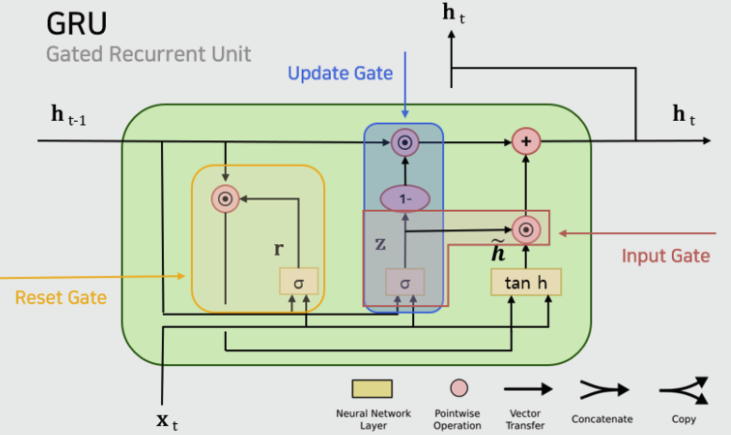

# Load Data

In [ ]:
import torch
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import random # 시드 고정을 위해
import os # 시드 고정을 위해

In [ ]:
SEED = 42
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
def reset_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)    # 파이썬 환경변수 시드 고정
    np.random.seed(seed)
    torch.manual_seed(seed) # cpu 연산 무작위 고정
    torch.cuda.manual_seed(seed) # gpu 연산 무작위 고정
    torch.backends.cudnn.deterministic = True  # cuda 라이브러리에서 Deterministic(결정론적)으로 예측하기 (예측에 대한 불확실성 제거 )

주식 데이터

In [ ]:
import pandas_datareader.data as web

df = web.DataReader('005930', 'naver', start='2021-01-01', end='2021-12-31')

print(f'{df.shape}')
df.head()

(248, 5)


,Open,High,Low,Close,Volume
Date,,,,,
2021-01-04,81000,84400,80200,83000,38655276
2021-01-05,81600,83900,81600,83900,35335669
2021-01-06,83300,84500,82100,82200,42089013
2021-01-07,82800,84200,82700,82900,32644642
2021-01-08,83300,90000,83000,88800,59013307


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 248 entries, 2021-01-04 to 2021-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Open    248 non-null    object
 1   High    248 non-null    object
 2   Low     248 non-null    object
 3   Close   248 non-null    object
 4   Volume  248 non-null    object
dtypes: object(5)
memory usage: 11.6+ KB


In [ ]:
df = df.astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 248 entries, 2021-01-04 to 2021-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Open    248 non-null    int64
 1   High    248 non-null    int64
 2   Low     248 non-null    int64
 3   Close   248 non-null    int64
 4   Volume  248 non-null    int64
dtypes: int64(5)
memory usage: 11.6 KB


## MinMax 스케일링

In [ ]:
data = df.to_numpy()
len(data)

248

In [ ]:
data[:1]

array([[   81000,    84400,    80200,    83000, 38655276]])

In [ ]:
mins = data.min(axis=0)
len(mins)

5

In [ ]:
mins[0]

68700

In [ ]:
maxs = data.max(axis=0)
len(maxs)

5

In [ ]:
maxs[0]

90300

In [ ]:
mins = data.min(axis=0)
sizes = data.max(axis=0) - mins

train = (data - mins) / sizes
len(train)

248

In [ ]:
train[0]

array([0.56944444, 0.54411765, 0.56132075, 0.63963964, 0.36992046])

복원

In [ ]:
train * sizes + mins

array([[   81000.,    84400.,    80200.,    83000., 38655276.],
       [   81600.,    83900.,    81600.,    83900., 35335669.],
       [   83300.,    84500.,    82100.,    82200., 42089013.],
       ...,
       [   80200.,    80400.,    79700.,    80300., 18226325.],
       [   80200.,    80200.,    78500.,    78800., 19794795.],
       [   78900.,    79500.,    78100.,    78300., 14236700.]])

## 시계열 데이터 전처리

In [ ]:
def transform_data(data,mins,sizes,seq_len = 10,pred_len = 5): # 5일씩 예측
    train = (data - mins) / sizes

    x_list = []
    y_list = []

    for i in range(seq_len,train.shape[0] + 1 - pred_len):
        x = train[i-seq_len:i]
        y = train[i:i+pred_len,3]

        x_list.append(x)
        y_list.append(y)
    x_arr = np.array(x_list)
    y_arr = np.array(y_list)

    return x_arr, y_arr

In [ ]:
x_arr, y_arr = transform_data(data,mins,sizes)
x_arr.shape, y_arr.shape

((234, 10, 5), (234, 5))

## Dataset

In [ ]:
class FinanceDataset(torch.utils.data.Dataset):
    def __init__(self,x,y=None):
        self.x = x
        self.y = y
    
    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self,idx):
        item = {}
        x = torch.Tensor(self.x[idx])
        item["x"] = x

        if self.y is not None:
            y = torch.Tensor(self.y[idx])
            item["y"] = y

        return item

In [ ]:
dt = FinanceDataset(x_arr,y_arr)

In [ ]:
len(dt)

234

## DataLoader

In [ ]:
dl = torch.utils.data.DataLoader(dt,batch_size=1,shuffle=False)

In [ ]:
batch = next(iter(dl))
batch

{'x': tensor([[[0.5694, 0.5441, 0.5613, 0.6396, 0.3699],
          [0.5972, 0.5257, 0.6274, 0.6802, 0.3294],
          [0.6759, 0.5478, 0.6509, 0.6036, 0.4118],
          [0.6528, 0.5368, 0.6792, 0.6351, 0.2966],
          [0.6759, 0.7500, 0.6934, 0.9009, 0.6183],
          [0.9861, 1.0000, 1.0000, 1.0000, 1.0000],
          [1.0000, 0.8015, 0.9198, 0.9820, 0.4922],
          [0.9769, 0.7941, 0.9811, 0.9414, 0.3384],
          [0.9259, 0.7500, 0.9623, 0.9414, 0.2203],
          [0.9769, 0.8162, 0.9292, 0.8649, 0.3062]]]),
 'y': tensor([[0.7297, 0.8198, 0.8288, 0.8694, 0.8108]])}

In [ ]:
batch["x"].shape, batch["y"].shape

(torch.Size([1, 10, 5]), torch.Size([1, 5]))

# LSTM Layer

Parameters
- input_size : 피쳐개수
- hidden_size : 은닉상태의 출력개수
- batch_first : 입력 데이터가 batch 먼저일 경우 True , 입력길이가 먼저일경우 False 
  
Output
- output 
- hidden_state
- cell_state 

In [ ]:
# (seq, batch  , features)
reset_seeds(SEED)
lstm_layer = torch.nn.LSTM(x_arr.shape[2],16,batch_first=False)

output, (final_hidden_state, final_cell_state) =  lstm_layer(batch["x"].permute(1,0,2))
output.shape

torch.Size([10, 1, 16])

In [ ]:
final_hidden_state.shape # (n_layer,1,feature)

torch.Size([1, 1, 16])

In [ ]:
final_cell_state.shape

torch.Size([1, 1, 16])

In [ ]:
# ( batch  ,seq, features)
reset_seeds(SEED)
lstm_layer = torch.nn.LSTM(x_arr.shape[2],16,batch_first=True)
output, (final_hidden_state, final_cell_state) =  lstm_layer(batch["x"])
output.shape

torch.Size([1, 10, 16])

In [ ]:
final_hidden_state.shape # (n_layer,1,feature)

torch.Size([1, 1, 16])

In [ ]:
final_cell_state.shape

torch.Size([1, 1, 16])

## Model

In [ ]:
class RNNLSTM(torch.nn.Module):
    # 기본변수, layer를 초기화해주는 생성자 seq_len = 10,pred_len = 5
    def __init__(self, input_dim, hidden_dim, seq_len=10, output_dim=5, layers=1):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.output_dim = output_dim
        self.layers = layers
        
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim, num_layers=layers,
                            # dropout = 0.1,
                            batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim, bias = True) 
        
    # 학습 초기화를 위한 함수
    def reset_hidden_state(self): 
        self.hidden = (
                torch.zeros(self.layers, self.seq_len, self.hidden_dim),
                torch.zeros(self.layers, self.seq_len, self.hidden_dim))
    
    # 예측을 위한 함수
    def forward(self, x):
        x, _status = self.lstm(x)
        x = self.fc(x[:, -1])
        return x

In [ ]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torchinfo
model = RNNLSTM(x_arr.shape[2],16)
torchinfo.summary(model,(32,x_arr.shape[1],x_arr.shape[2]))

Layer (type:depth-idx)                   Output Shape              Param #
RNNLSTM                                  [32, 5]                   --
├─LSTM: 1-1                              [32, 10, 16]              1,472
├─Linear: 1-2                            [32, 5]                   85
Total params: 1,557
Trainable params: 1,557
Non-trainable params: 0
Total mult-adds (M): 0.47
Input size (MB): 0.01
Forward/backward pass size (MB): 0.04
Params size (MB): 0.01
Estimated Total Size (MB): 0.05

## Train

In [ ]:
def train_loop(dataloader,model,loss_fn,optimizer,device):
    epoch_loss = 0
    model.train()
    for batch in dataloader:
        pred = model(batch["x"].to(device))
        loss = loss_fn(pred,batch["y"].to(device))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(dataloader)

    return epoch_loss

In [ ]:
@torch.no_grad()
def test_loop(dataloader,model,loss_fn,device):
    epoch_loss = 0
    model.eval()

    pred_list = []
    for batch in dataloader:
        pred = model(batch["x"].to(device))

        if batch.get("y") is not None:
            loss = loss_fn(pred,batch["y"].to(device))
            epoch_loss += loss.item()

        pred = pred.to("cpu").numpy()
        pred_list.append(pred)

    epoch_loss /= len(dataloader)

    pred = np.concatenate(pred_list)
    return epoch_loss,pred

In [ ]:
n_splits = 5
num_features = x_arr.shape[2]
hidden_size = 16
batch_size = 32
epochs = 500
loss_fn = torch.nn.MSELoss()

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

cv = KFold(n_splits=n_splits,shuffle=True, random_state=SEED)

In [ ]:
is_holdout = False

reset_seeds(SEED)
best_score_list = []
for i,(tri,vai) in enumerate(cv.split(x_arr)):
    model = RNNLSTM(num_features,hidden_size).to(device)
    optimizer = torch.optim.Adam(model.parameters())

    # dataset
    train_dt = FinanceDataset(x_arr[tri],y_arr[tri])
    valid_dt = FinanceDataset(x_arr[vai],y_arr[vai])

    # dataloader
    train_dl = torch.utils.data.DataLoader(train_dt,batch_size=batch_size,shuffle=True)
    valid_dl = torch.utils.data.DataLoader(valid_dt,batch_size=batch_size,shuffle=False)

    best_score = np.inf
    patience = 0 
    for epoch in tqdm(range(epochs)):
        # seq별 hidden state reset
        model.reset_hidden_state()
        
        train_loss = train_loop(train_dl, model, loss_fn, optimizer, device)
        valid_loss,pred = test_loop(valid_dl,model,loss_fn,device)
        pred = pred * sizes[3] + mins[3]
        true = y_arr[vai] * sizes[3] + mins[3]
        score = mean_absolute_error(true,pred)
        patience += 1
        if best_score > score:
            patience = 0
            best_score = score
            torch.save(model.state_dict(),f"model_{i}.pth")

        if patience == 5:
            break
    print(f"Fold ({i}), BEST MAE: {best_score}")
    best_score_list.append(best_score)
    if is_holdout:
        break

  0%|          | 0/500 [00:00<?, ?it/s]

Fold (0), BEST MAE: 1126.0974884682514


  0%|          | 0/500 [00:00<?, ?it/s]

Fold (1), BEST MAE: 1310.3584124626


  0%|          | 0/500 [00:00<?, ?it/s]

Fold (2), BEST MAE: 1548.5081667636302


  0%|          | 0/500 [00:00<?, ?it/s]

Fold (3), BEST MAE: 1295.4124864943483


  0%|          | 0/500 [00:00<?, ?it/s]

Fold (4), BEST MAE: 1245.0423780358356


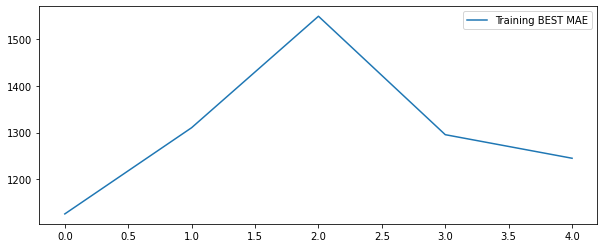

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 4))
plt.plot(best_score_list, label="Training BEST MAE")
plt.legend()
plt.show()

# GRU Layer

Parameters
- input_size : 피쳐개수
- hidden_size : 은닉상태의 출력개수
- batch_first : 입력 데이터가 batch 먼저일 경우 True , 입력길이가 먼저일경우 False 
  
Output
- output 
- hidden_state

In [ ]:
reset_seeds(SEED)
gru_layer = torch.nn.GRU(x_arr.shape[2],16,batch_first=True)
output, final_hidden_state = gru_layer(batch["x"])
output.shape, final_hidden_state.shape

(torch.Size([1, 10, 16]), torch.Size([1, 1, 16]))

## Model

In [ ]:
class RNNGRU(torch.nn.Module):
    def __init__(self,input_size,hidden_size):
        super().__init__()
        self.rnn_layer = torch.nn.LSTM(input_size,hidden_size,batch_first=True)
        self.linear_layer = torch.nn.Linear(hidden_size,hidden_size//2)
        self.relu = torch.nn.ReLU()
        self.output_layer = torch.nn.Linear(hidden_size//2,5)
    def forward(self,x):
        output , (hn,cn) = self.rnn_layer(x)
        x = output[:,-1]
        x = self.linear_layer(x)
        x = self.relu(x)
        x = self.output_layer(x)
        return x

In [ ]:
import torchinfo

model = RNNGRU(x_arr.shape[2],16)
torchinfo.summary(model,(32,x_arr.shape[1],x_arr.shape[2]))

Layer (type:depth-idx)                   Output Shape              Param #
RNNGRU                                   [32, 5]                   --
├─LSTM: 1-1                              [32, 10, 16]              1,472
├─Linear: 1-2                            [32, 8]                   136
├─ReLU: 1-3                              [32, 8]                   --
├─Linear: 1-4                            [32, 5]                   45
Total params: 1,653
Trainable params: 1,653
Non-trainable params: 0
Total mult-adds (M): 0.48
Input size (MB): 0.01
Forward/backward pass size (MB): 0.04
Params size (MB): 0.01
Estimated Total Size (MB): 0.06

## Train

In [ ]:
is_holdout = False

reset_seeds(SEED)
best_score_list = []
for i,(tri,vai) in enumerate(cv.split(x_arr)):
    model = RNNGRU(num_features,hidden_size).to(device)
    optimizer = torch.optim.Adam(model.parameters())

    # dataset
    train_dt = FinanceDataset(x_arr[tri],y_arr[tri])
    valid_dt = FinanceDataset(x_arr[vai],y_arr[vai])

    # dataloader
    train_dl = torch.utils.data.DataLoader(train_dt,batch_size=batch_size,shuffle=True)
    valid_dl = torch.utils.data.DataLoader(valid_dt,batch_size=batch_size,shuffle=False)

    best_score = np.inf
    patience = 0 
    for epoch in tqdm(range(epochs)):
        train_loss = train_loop(train_dl, model, loss_fn, optimizer, device)
        valid_loss,pred = test_loop(valid_dl,model,loss_fn,device)
        pred = pred * sizes[3] + mins[3]
        true = y_arr[vai] * sizes[3] + mins[3]
        score = mean_absolute_error(true,pred)
        patience += 1
        if best_score > score:
            patience = 0
            best_score = score
            torch.save(model.state_dict(),f"model_{i}.pth")

        if patience == 5:
            break
    print(f"Fold ({i}), BEST MAE: {best_score}")
    best_score_list.append(best_score)
    if is_holdout:
        break

  0%|          | 0/500 [00:00<?, ?it/s]

Fold (0), BEST MAE: 1108.7391450922541


  0%|          | 0/500 [00:00<?, ?it/s]

Fold (1), BEST MAE: 1317.894710719332


  0%|          | 0/500 [00:00<?, ?it/s]

Fold (2), BEST MAE: 1481.7823304521276


  0%|          | 0/500 [00:00<?, ?it/s]

Fold (3), BEST MAE: 1212.5271920711434


  0%|          | 0/500 [00:00<?, ?it/s]

Fold (4), BEST MAE: 1400.4468325407609


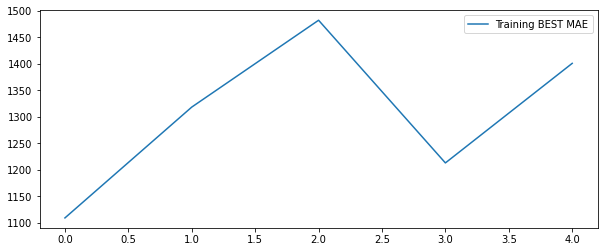

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 4))
plt.plot(best_score_list, label="Training BEST MAE")
plt.legend()
plt.show()